__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display, display_html  # print nicely
from matplotlib.lines import Line2D  # matplotlib custom lines
from scipy import stats  # statistical tests
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 3 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (20, 8)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

PATH_PROC = "./data/processed"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

"""
Event1: 1162-1400
Event2: 1958-2080
Event3: 2596-2890
"""
event_ranges = [(1162, 1400), (1958, 2080), (2596, 2890)]

CONDS = ["AVAS", "RadioTalk", "TaxiDriver"]

groups = [
    "Buildings",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    "Inside Car",
    "Nature",
    "Roads",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette

colors = [next(palette) for i in range(3)]

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Helper functions__

In [3]:
def normalize_series(s):
    """Normalize a series (dataframe column)."""
    # Mean normalization: (s - s.min()) / (s.max() - s.min())
    # Std normalization: (s - s.mean()) / s.std()
    return (s - s.min()) / (s.max() - s.min())

__Read participants and questionnaires cleaned data__

In [4]:
parts = pd.read_csv("./participants_clean.csv", keep_default_na=False)
parts = parts.set_index("id")  # set uid column as index (remove default)

quests = pd.read_csv("./questionnaires.csv", keep_default_na=False)
quests = quests.set_index("id")  # set uid column as index (remove default)

conds = sorted(parts.condition.unique().tolist())

display(parts)
display(quests)

,date,expo,side,condition,nulls_%,sky_%,insidecar_%,questionnaire
id,,,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,1.610,13.740,2.359,No
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,0.037,0.674,25.421,No
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,0.037,33.134,0.786,No
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,0.824,18.607,2.845,No
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,0.225,26.994,0.262,No
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,0.300,32.160,0.000,No
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,0.674,15.462,5.054,No
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,1.797,3.370,11.718,No


,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,side,condition
id,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,Yes,80,58,more than 10 times,MSW,right,RadioTalk
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,No,0,5,once,MSW,left,RadioTalk
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,No,4,2,once,MSW,right,RadioTalk
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,No,3,1,less than 10 times,MSW,right,TaxiDriver
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,No,0,3,less than 10 times,MSW,right,RadioTalk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,No,0,25,once,BMBF,right,RadioTalk
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,Yes,99,9,less than 10 times,BMBF,right,TaxiDriver
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,No,39,0,never,BMBF,right,RadioTalk


__Descriptive statistics, distribution and correlation matrix of all questionnaire numerical variables__

,Intention,Usefulness,Ease,Trust,Age,Driving,Play
count,9507.000,9507.000,9507.000,9507.000,9507.000,9507.000,9507.000
mean,61.226,63.912,64.667,66.581,30.052,16.411,9.051
std,34.348,32.229,31.419,31.992,21.351,22.049,21.221
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,34.000,50.000,50.000,47.000,12.000,0.000,0.000
50%,66.000,70.000,70.000,75.000,21.000,6.000,1.000
75%,100.000,99.000,100.000,100.000,46.500,29.000,7.000
max,100.000,100.000,100.000,100.000,99.000,99.000,99.000


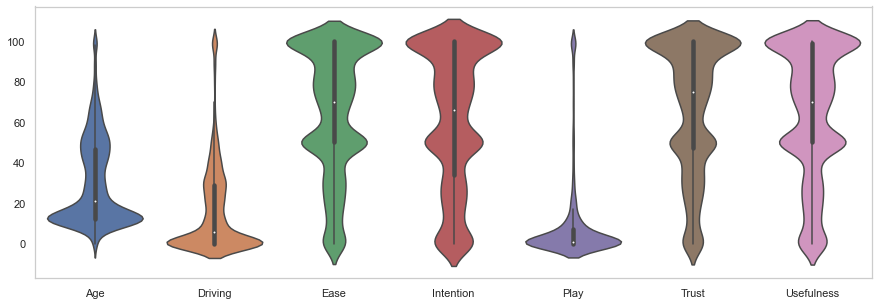

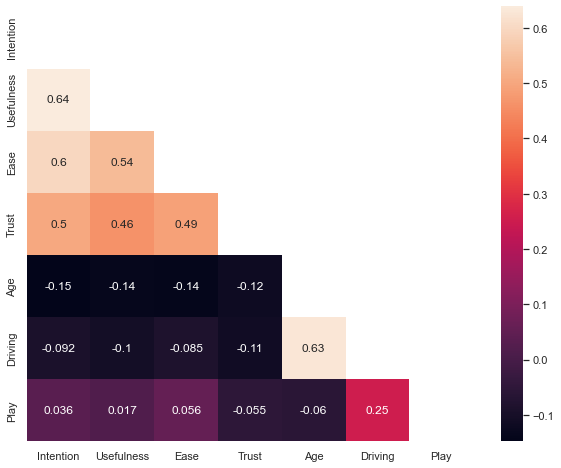

In [7]:
cols = sorted(quests.describe().columns.tolist())

display(quests.describe())

plt.figure(figsize=(15, 5))
ax = sns.violinplot(
    data=quests,
    order=cols,
    scale="width",
)
ax.grid(False)
plt.show()

# remove the number of frames as it's uninformative
parts_an = copy.deepcopy(quests)

cm_parts = parts_an.corr(method="pearson")
# # display pearson correlation coeficients on a table
# display(cm_parts)

# generate a mask to drop the upper part of the matrix (duplicated info)
mask = np.triu(np.ones_like(cm_parts, dtype=np.bool))

# figure size
plt.figure(figsize=(10, 8))

# display the correlation matrix as a heatmap
sns.heatmap(cm_parts, annot=True, mask=mask)
plt.show()

__Population count and density for each categorical variable__

,count,%
condition,,
AVAS,3284,34.54
RadioTalk,3046,32.04
TaxiDriver,3177,33.42
,count,%
expo,,
BMBF,1150,12.10
MSW,8357,87.90
,count,%
Gender,,


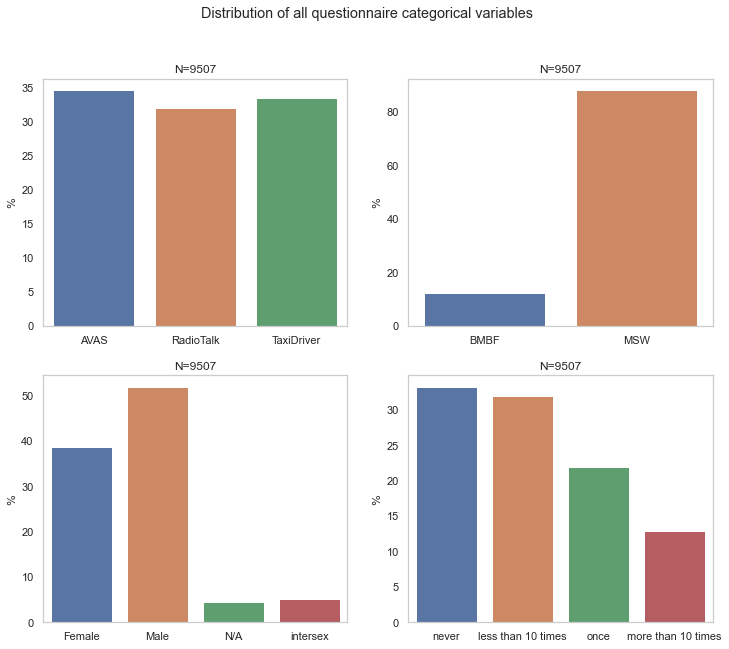

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle(f"Distribution of all questionnaire categorical variables")
# fig.tight_layout()

# categorical columns to compute descriptive statistics
cols = ["condition", "expo", "Gender", "VR"]
c = 0
r = 0
tables_joint = ""
for i, col in enumerate(cols):  # for each defined column
    counts = quests[col].value_counts()
    percents = quests[col].value_counts(normalize=True).mul(100)
    df = pd.DataFrame({"count": counts, "%": percents})
    df.index.name = col
    if col != "VR":
        df = df.sort_index()
        COLS = sorted(quests[col].unique().tolist())
    else:
        COLS = df.index.tolist()

    ax = sns.barplot(data=df, x=COLS, y="%", ax=axes[r, c])
    ax.grid(False)
    ax.set_title(f"N={quests.index.size}")
    df["%"] = df["%"].map("{:.2f}".format)
    df = df.style.set_table_attributes("style='display:inline'")
    tables_joint += df._repr_html_()

    if i == 1:
        r = 1
        c = 0
    else:
        c += 1

display_html(tables_joint, raw=True)
plt.show()

For more plots about conditions, sides, and exhibition distributions, check:
[checks/sides_and_conditions.ipynb](./checks/sides_and_conditions.ipynb)

In [5]:
grp_len = pd.read_csv("./group_lengths.csv", index_col=0)
display(grp_len)

grp_len = grp_len.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
display(grp_len)
display(grp_len.describe())

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,18.414,0.924,1.122,1.881,3.597,18.282,0.000,0.000,1.155,13.332,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,0.594,0.000,28.677,0.297,30.360,0.000,0.000,0.363,4.620,0.000
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.000,0.000,0.627,0.924,0.000,0.000,0.000,0.363,9.207,0.000
37d7e67934974217830bb429bba7fd76,17.259,2.508,1.122,4.719,5.049,1.122,0.330,0.000,2.013,18.777,0.000
42bac596059749b5b8e8e83ae61de9b4,34.584,0.000,0.000,0.528,6.402,0.000,0.000,0.000,2.310,10.362,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,0.000,0.000,6.435,2.739,0.000,0.000,0.000,1.023,8.382,0.000
611d35a7c3e940cc82495e53c2a8532d,19.041,0.000,0.000,24.288,4.686,2.838,0.000,0.000,1.056,9.174,0.363
3b6fda285d9e412eb081986b2f22a2e3,7.821,0.000,0.462,18.381,0.660,16.599,0.000,1.122,5.874,5.577,0.000
18ffb0abdc8642098c479380bfa533d1,14.718,0.264,0.000,5.478,4.950,6.402,0.000,0.000,1.485,11.418,0.627


,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,18.414,0.924,1.122,1.881,3.597,18.282,0.000,0.000,1.155,13.332,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,0.594,0.000,28.677,0.297,30.360,0.000,0.000,0.363,4.620,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.000,0.000,0.627,0.924,0.000,0.000,0.000,0.363,9.207,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,17.259,2.508,1.122,4.719,5.049,1.122,0.330,0.000,2.013,18.777,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,34.584,0.000,0.000,0.528,6.402,0.000,0.000,0.000,2.310,10.362,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,0.000,0.000,6.435,2.739,0.000,0.000,0.000,1.023,8.382,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,19.041,0.000,0.000,24.288,4.686,2.838,0.000,0.000,1.056,9.174,0.363,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,7.821,0.000,0.462,18.381,0.660,16.599,0.000,1.122,5.874,5.577,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,14.718,0.264,0.000,5.478,4.950,6.402,0.000,0.000,1.485,11.418,0.627,BMBF,left,RadioTalk,Yes


,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,15.159,0.441,0.274,20.542,2.607,10.988,0.029,0.031,1.162,7.226,0.171
std,13.156,0.842,0.517,18.498,2.724,12.850,0.142,0.169,1.306,3.626,0.553
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.838,0.000,0.000,5.643,0.363,1.749,0.000,0.000,0.000,4.224,0.000
50%,12.804,0.000,0.000,14.454,1.815,6.831,0.000,0.000,0.792,6.633,0.000
75%,24.816,0.561,0.396,31.779,4.026,15.312,0.000,0.000,1.749,9.471,0.000
max,59.136,9.636,9.702,88.143,21.549,82.071,3.267,4.818,15.741,24.090,7.557


Final groups

In [6]:
final_groups = ["Buildings", "Inside Car", "Nature", "condition"]

# length
gaze_len = grp_len[final_groups]
gaze_len["Cars and Pedestrians"] = (
    grp_len["Dynamic Cars"] + grp_len["Dynamic Pedestrians"]
)
gaze_len["Roads"] = grp_len["Static Cars"] + grp_len["Roads"]
gaze_len["Street Objects"] = (
    grp_len["Street Objects"] + grp_len["Static Pedestrians"]
)
gaze_len["Traffic Signs"] = (
    grp_len["Traffic Signs"] + grp_len["Traffic Lights"]
)
# order them alphabetically
cols = sorted(gaze_len.columns.tolist())
gaze_len = gaze_len.reindex(columns=cols)

# TR vs non-TR
gaze_ltr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ltr["TR"] = (
    gaze_len["Cars and Pedestrians"]
    + gaze_len["Roads"]
    + gaze_len["Traffic Signs"]
    + gaze_len["Inside Car"]
)
gaze_ltr["non-TR"] = (
    gaze_len["Buildings"] + gaze_len["Nature"] + gaze_len["Street Objects"]
)
gaze_ltr["condition"] = gaze_len["condition"]
# order them alphabetically
cols = sorted(gaze_ltr.columns.tolist())
gaze_ltr = gaze_ltr.reindex(columns=cols)

display(gaze_len.describe())
display(gaze_ltr.describe())

,Buildings,Cars and Pedestrians,Inside Car,Nature,Roads,Street Objects,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,15.159,0.715,20.542,2.607,11.017,1.193,7.396
std,13.156,1.092,18.498,2.724,12.851,1.338,3.803
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.838,0.000,5.643,0.363,1.782,0.000,4.290
50%,12.804,0.297,14.454,1.815,6.864,0.825,6.765
75%,24.816,0.957,31.779,4.026,15.345,1.815,9.669
max,59.136,11.187,88.143,21.549,82.071,16.401,27.918


,TR,non-TR
count,24356.000,24356.000
mean,39.670,18.959
std,20.934,15.722
min,3.102,0.000
25%,20.823,4.282
50%,36.366,16.599
75%,57.255,30.756
max,88.143,66.099


In [7]:
parts[parts.questionnaire == "Yes"].index.size

9507

In [8]:
quests.index.size

9507

In [9]:
select = parts[parts.questionnaire == "Yes"]
gaze_ltr = gaze_ltr.join(parts[["expo", "side", "questionnaire"]], how="outer")
select = gaze_ltr[gaze_ltr.questionnaire == "Yes"]
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    "Gender",
    "Age",
    "Aviophobia",
    "Driving",
    "Play",
    "VR",
]
gaze_ltr = gaze_ltr.join(quests[cols], how="outer")

In [10]:
gaze_ltr = gaze_ltr[gaze_ltr.questionnaire == "Yes"]
gaze_ltr

,TR,condition,non-TR,expo,side,questionnaire,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR
000966a73bce402d8d92ece7eb13e1f7,32.439,AVAS,14.850,BMBF,right,Yes,50.000,50.000,50.000,68.000,Female,15.000,No,0.000,4.000,once
000ea0a15c0d476f89d084116e7b1e86,59.829,AVAS,1.848,MSW,right,Yes,88.000,56.000,25.000,100.000,Male,12.000,No,0.000,9.000,less than 10 times
0015a3c9144248fb9571311e1140d7d0,37.092,AVAS,25.278,MSW,right,Yes,71.000,50.000,83.000,50.000,Male,23.000,Yes,4.000,4.000,more than 10 times
0018e0af4c064093bab6f1d1d627b37f,32.670,TaxiDriver,15.939,MSW,left,Yes,100.000,89.000,82.000,100.000,Female,12.000,No,0.000,0.000,less than 10 times
001f482723604d929eff67b8e59f1db1,26.532,RadioTalk,19.272,MSW,left,Yes,37.000,39.000,45.000,100.000,N/A,81.000,No,0.000,5.000,less than 10 times
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe8b0db1e4640d695641d7b6bd2099d,16.632,TaxiDriver,47.091,MSW,right,Yes,100.000,100.000,100.000,100.000,Male,17.000,No,0.000,50.000,more than 10 times
ffeaa9becd4f451389d253b8ac0ba1bc,16.962,AVAS,39.996,MSW,left,Yes,83.000,0.000,87.000,61.000,Female,12.000,No,0.000,2.000,less than 10 times
fff21f23099e4e70b09ebc727e6365e5,65.769,AVAS,0.000,MSW,left,Yes,50.000,50.000,56.000,89.000,Male,19.000,No,0.000,30.000,once
fff77d4abc9b4937a78f5e4a8b9def12,74.184,TaxiDriver,0.000,MSW,right,Yes,50.000,30.000,100.000,50.000,Male,46.000,No,27.000,0.000,less than 10 times


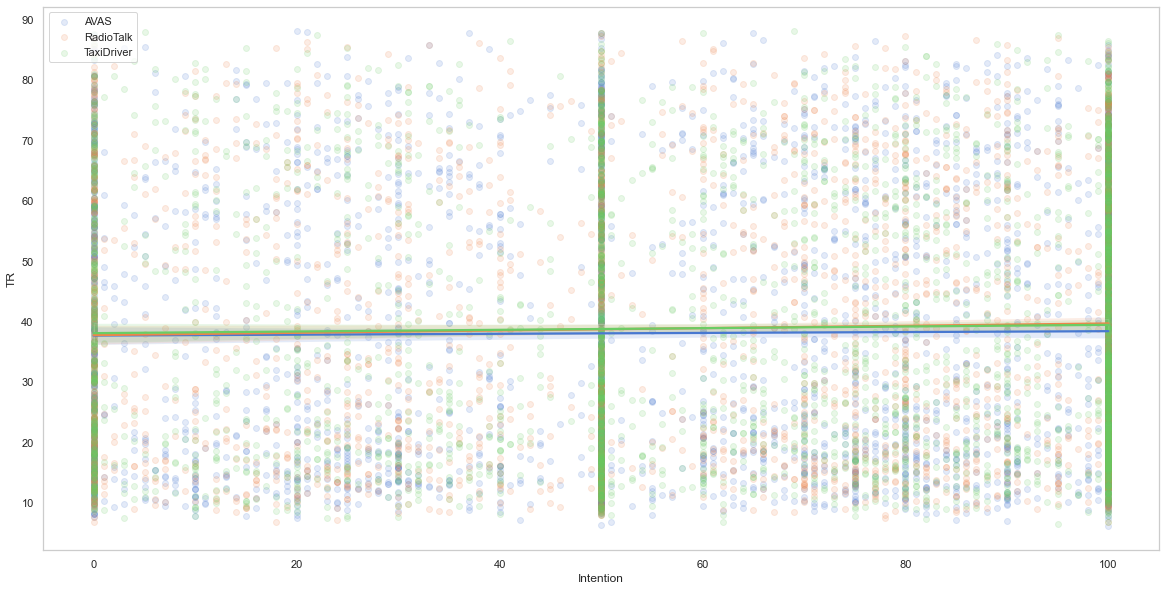

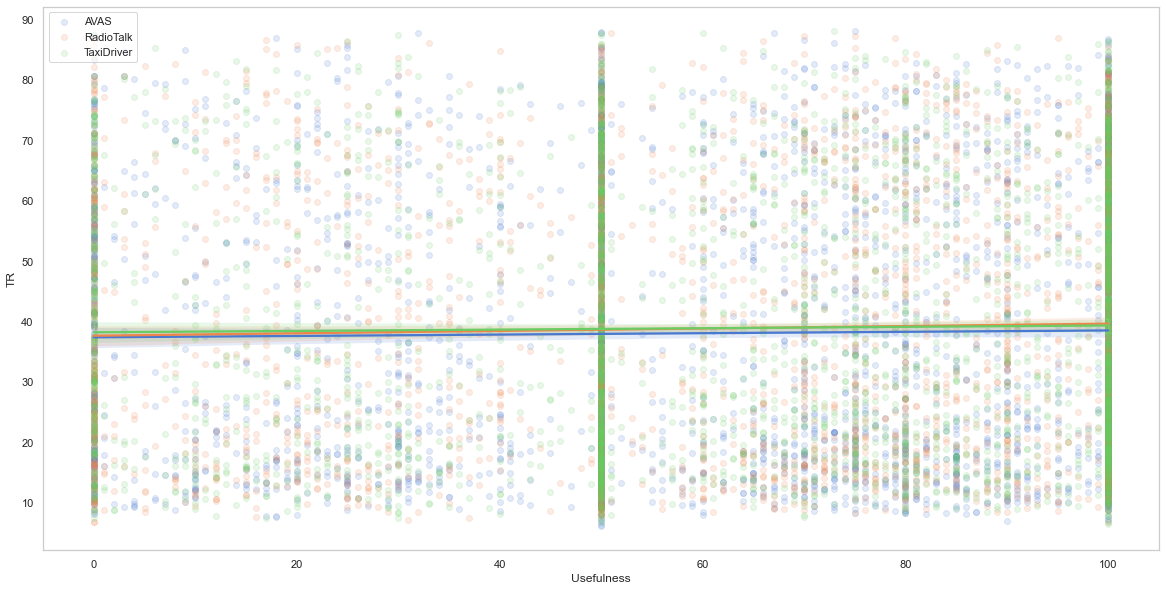

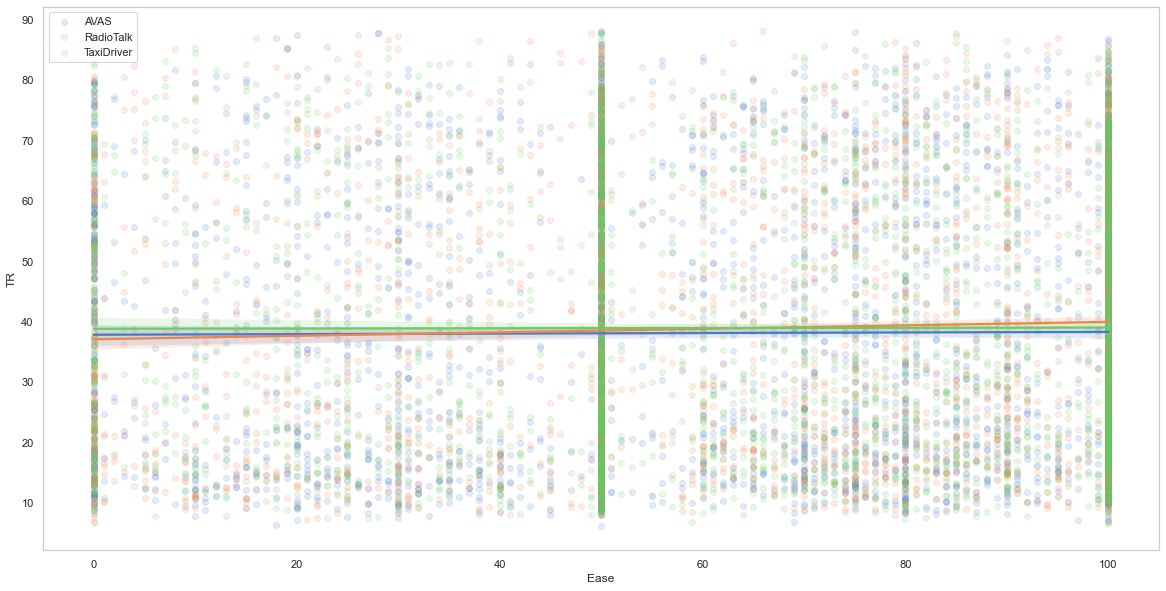

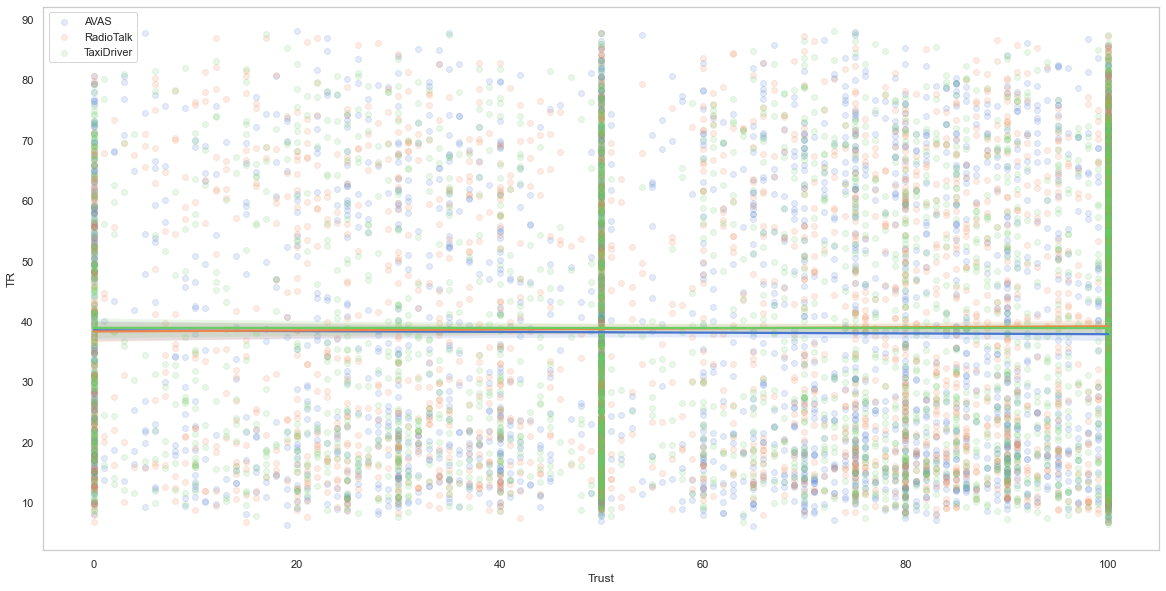

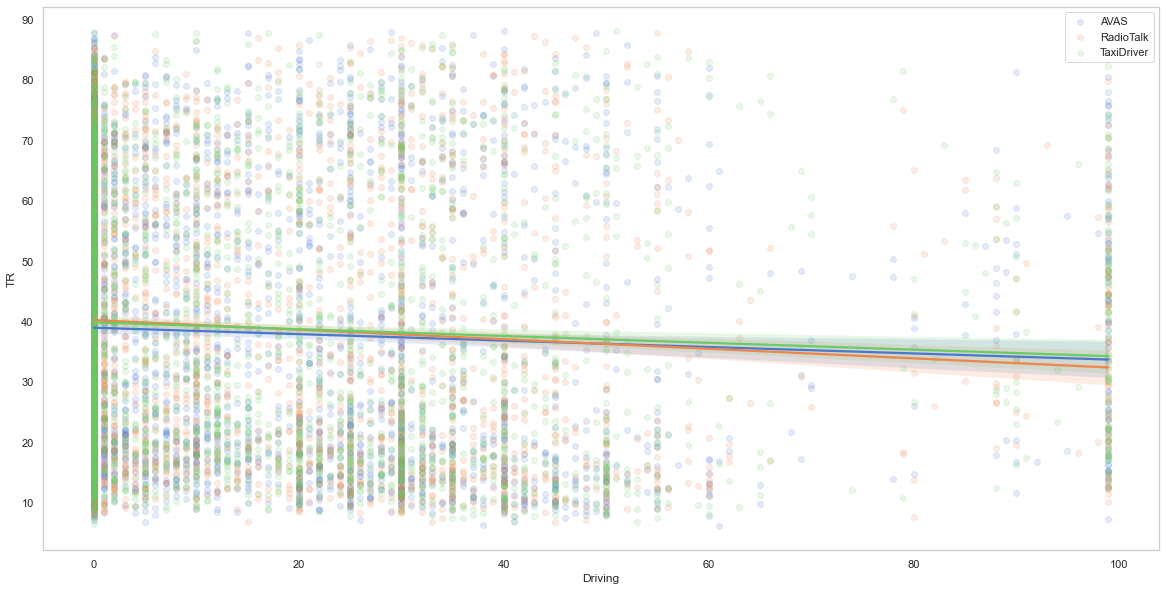

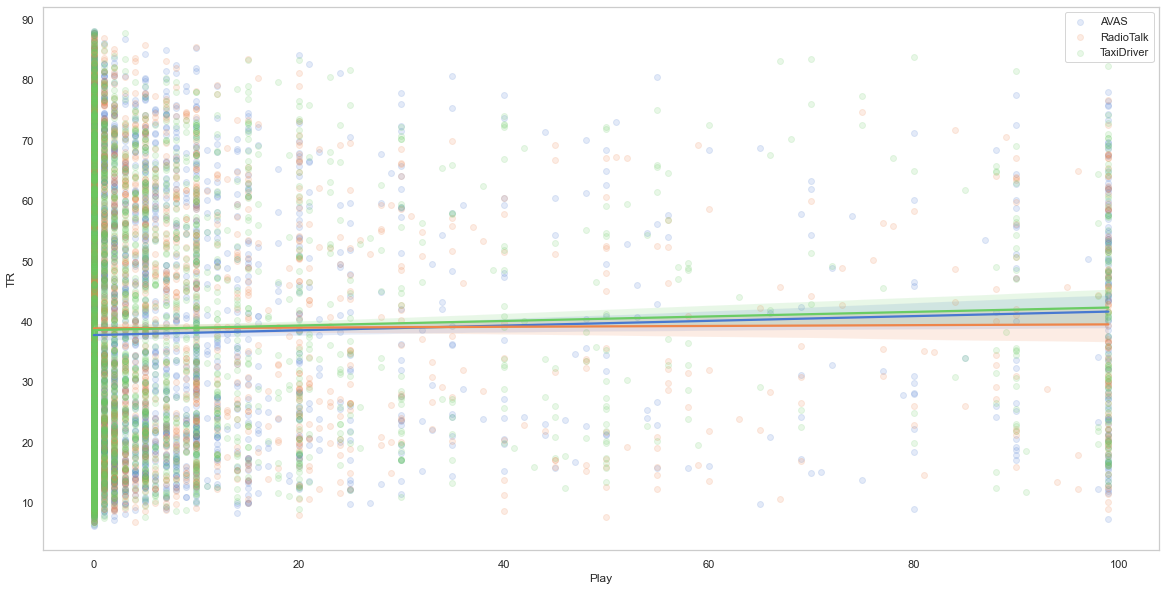

In [11]:
# palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    # "Aviophobia",
    "Driving",
    "Play",
]
conds = ["AVAS", "RadioTalk", "TaxiDriver"]
for col in cols:
    palette = itertools.cycle(
        sns.color_palette(palette="muted")
    )  # color palette
    plt.figure(figsize=(20, 10))
    for cnd in conds:
        ax = sns.regplot(
            data=gaze_ltr[gaze_ltr.condition == cnd],
            y="TR",
            x=col,
            color=next(palette),
            label=cnd,
            scatter_kws={"alpha": 0.15},
        )
        ax.grid(False)
    plt.legend()
    plt.show()

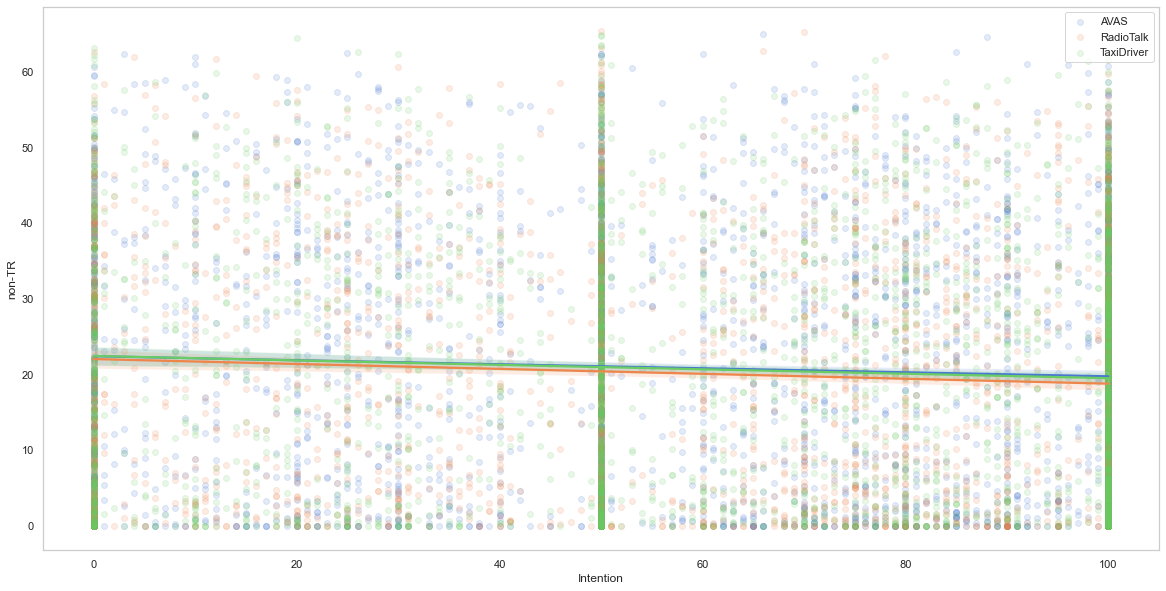

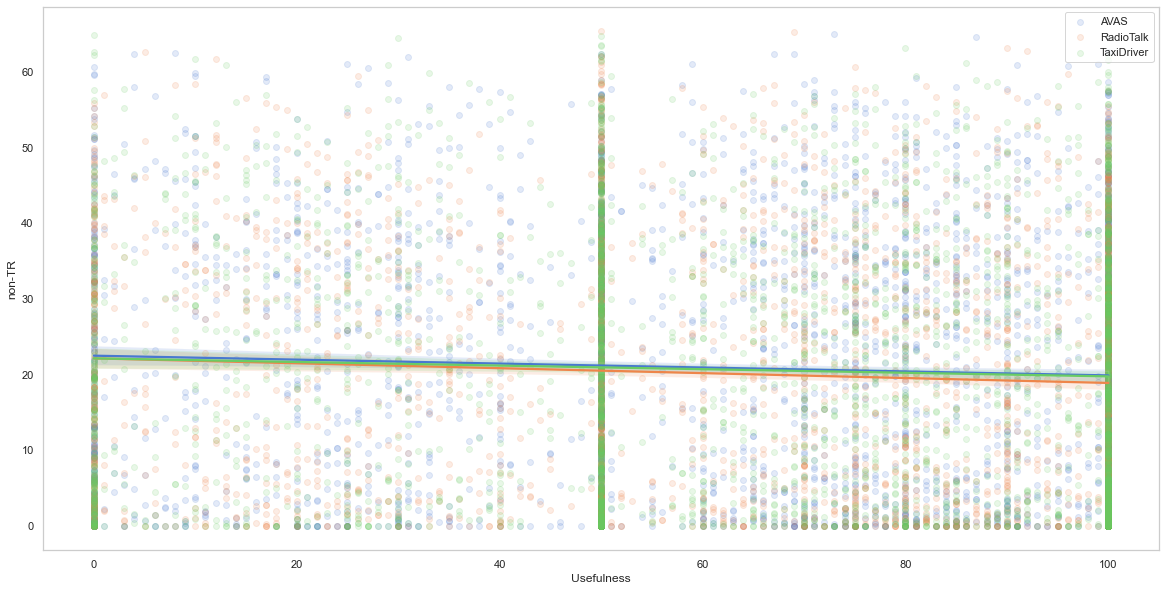

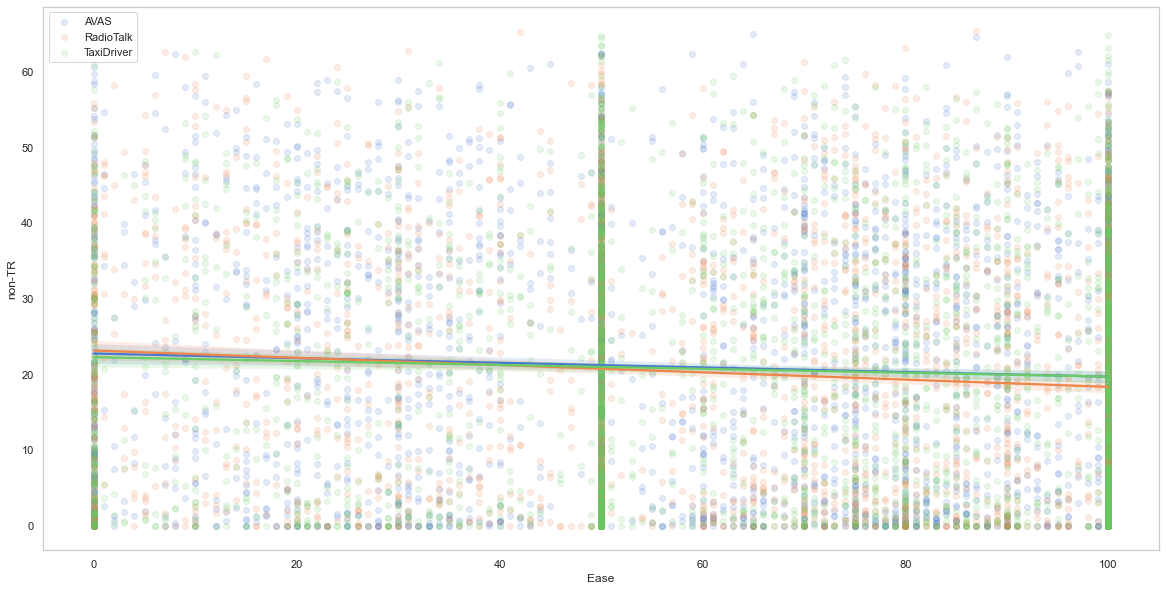

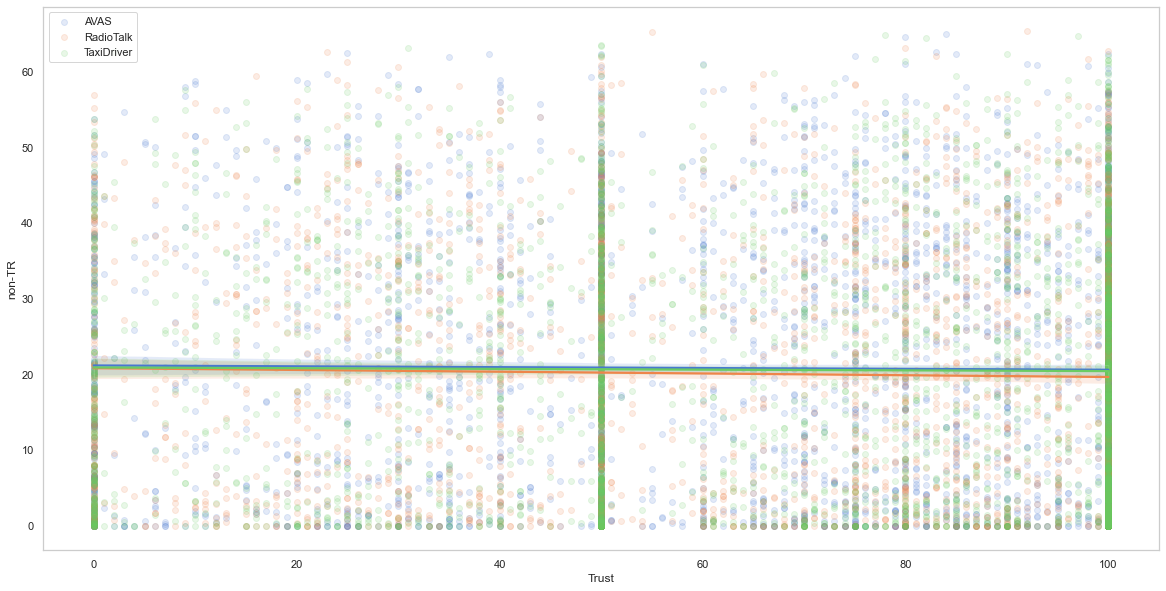

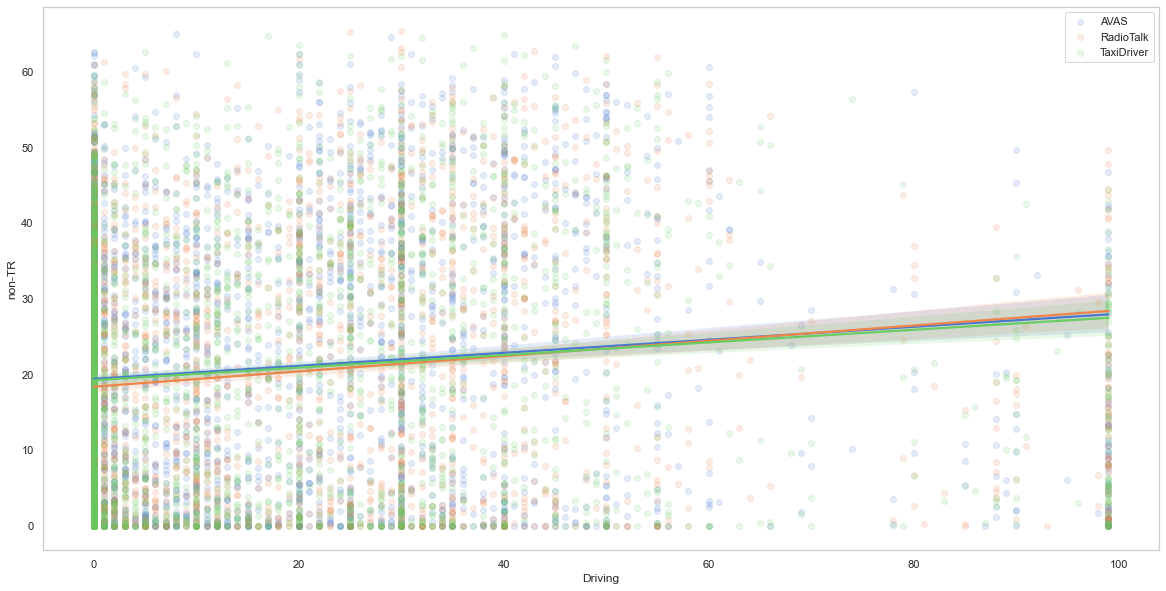

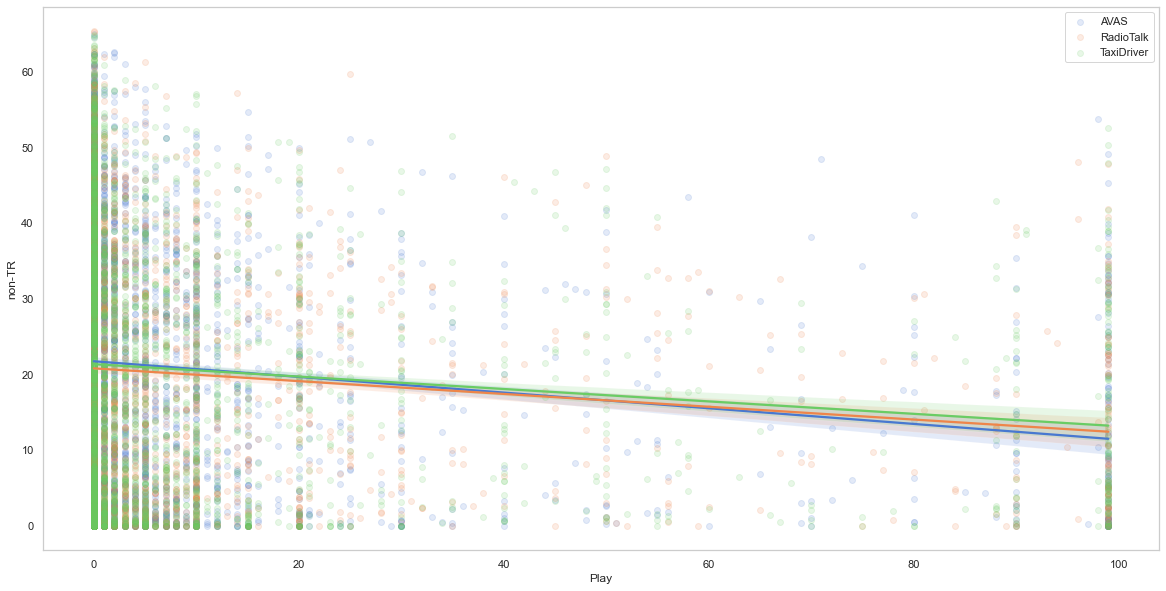

In [12]:
# palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    # "Aviophobia",
    "Driving",
    "Play",
]
conds = ["AVAS", "RadioTalk", "TaxiDriver"]
for col in cols:
    palette = itertools.cycle(
        sns.color_palette(palette="muted")
    )  # color palette
    plt.figure(figsize=(20, 10))
    for cnd in conds:
        ax = sns.regplot(
            data=gaze_ltr[gaze_ltr.condition == cnd],
            y="non-TR",
            x=col,
            color=next(palette),
            label=cnd,
            scatter_kws={"alpha": 0.15},
        )
    ax.grid(False)
    plt.legend()
    plt.show()